# Important Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# imports to apply decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Data Preprocessing

## Loading and Exploring the Data

In [2]:
# Load the data
df = pd.read_csv('Mall_Customers.csv')

In [3]:
# Display the first 5 rows of the data
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
# Check for missing values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
# Drop the CustomerID column
df.drop('CustomerID', axis=1, inplace=True)

# Search for duplicate rows
print(df.duplicated().sum())

0


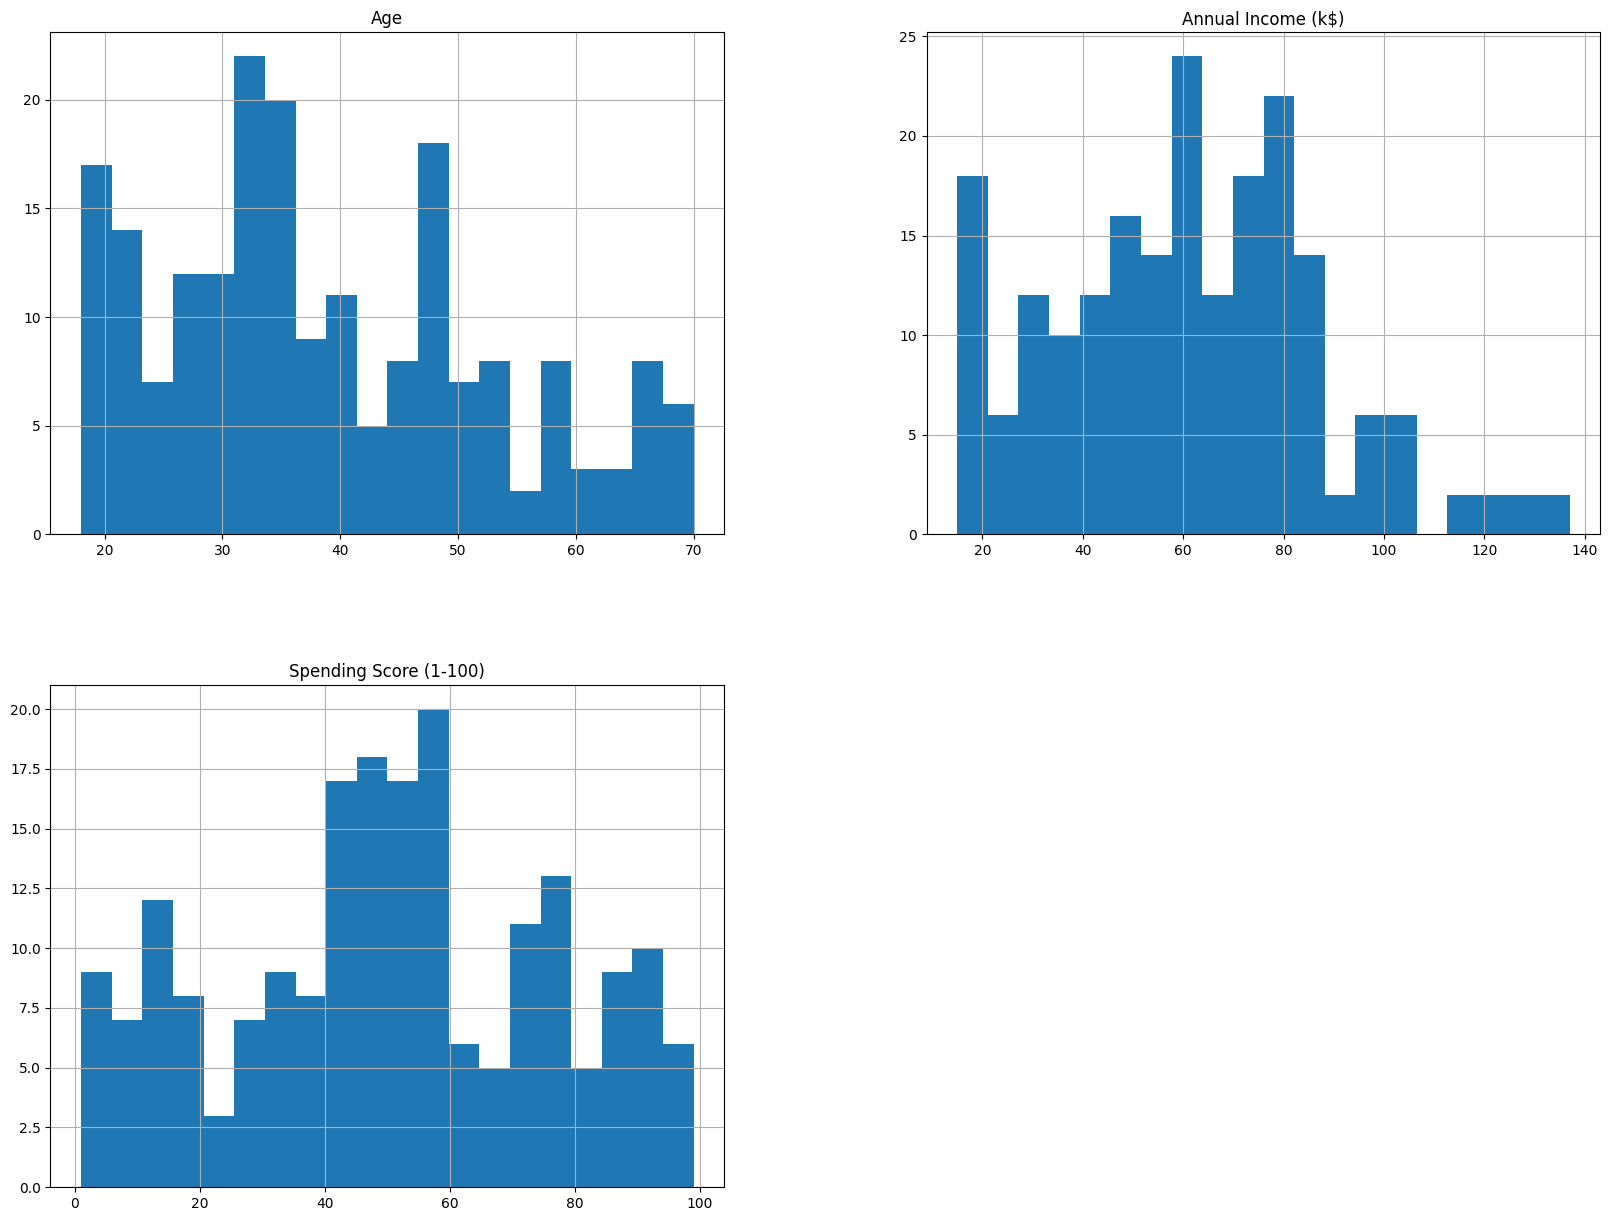

In [8]:
# Plor the distribution of the all columns
df.hist(bins=20, figsize=(20, 15))
plt.show()

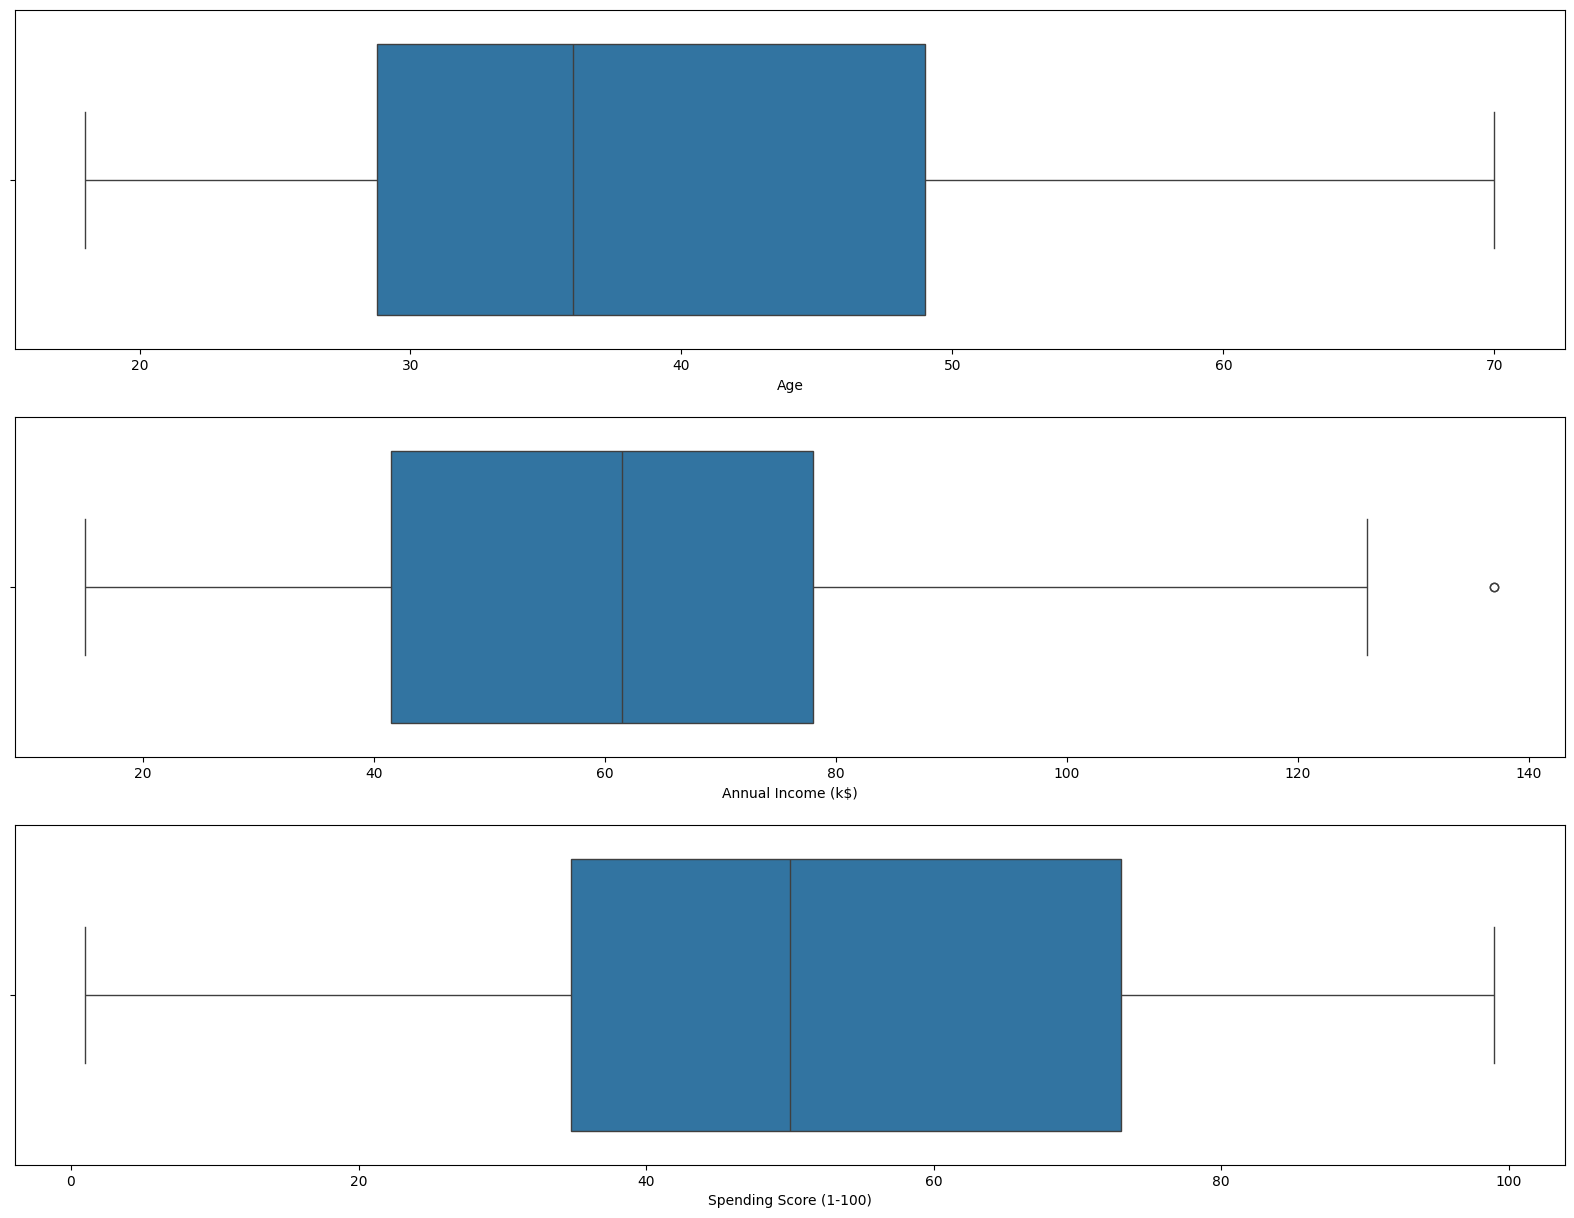

In [9]:
# Plot using boxplot to check for outliers
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
sns.boxplot(x=df['Age'], orient='h')
plt.subplot(3, 1, 2)
sns.boxplot(x=df['Annual Income (k$)'], orient='h')
plt.subplot(3, 1, 3)
sns.boxplot(x=df['Spending Score (1-100)'], orient='h')
plt.show()

In [10]:
# This part will be applied to all columns except "Gender" and i will use IQR to remove outliers
def remove_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df_out

df = remove_outliers('Age')
df = remove_outliers('Annual Income (k$)')
df = remove_outliers('Spending Score (1-100)')

print(df.shape)

(198, 4)


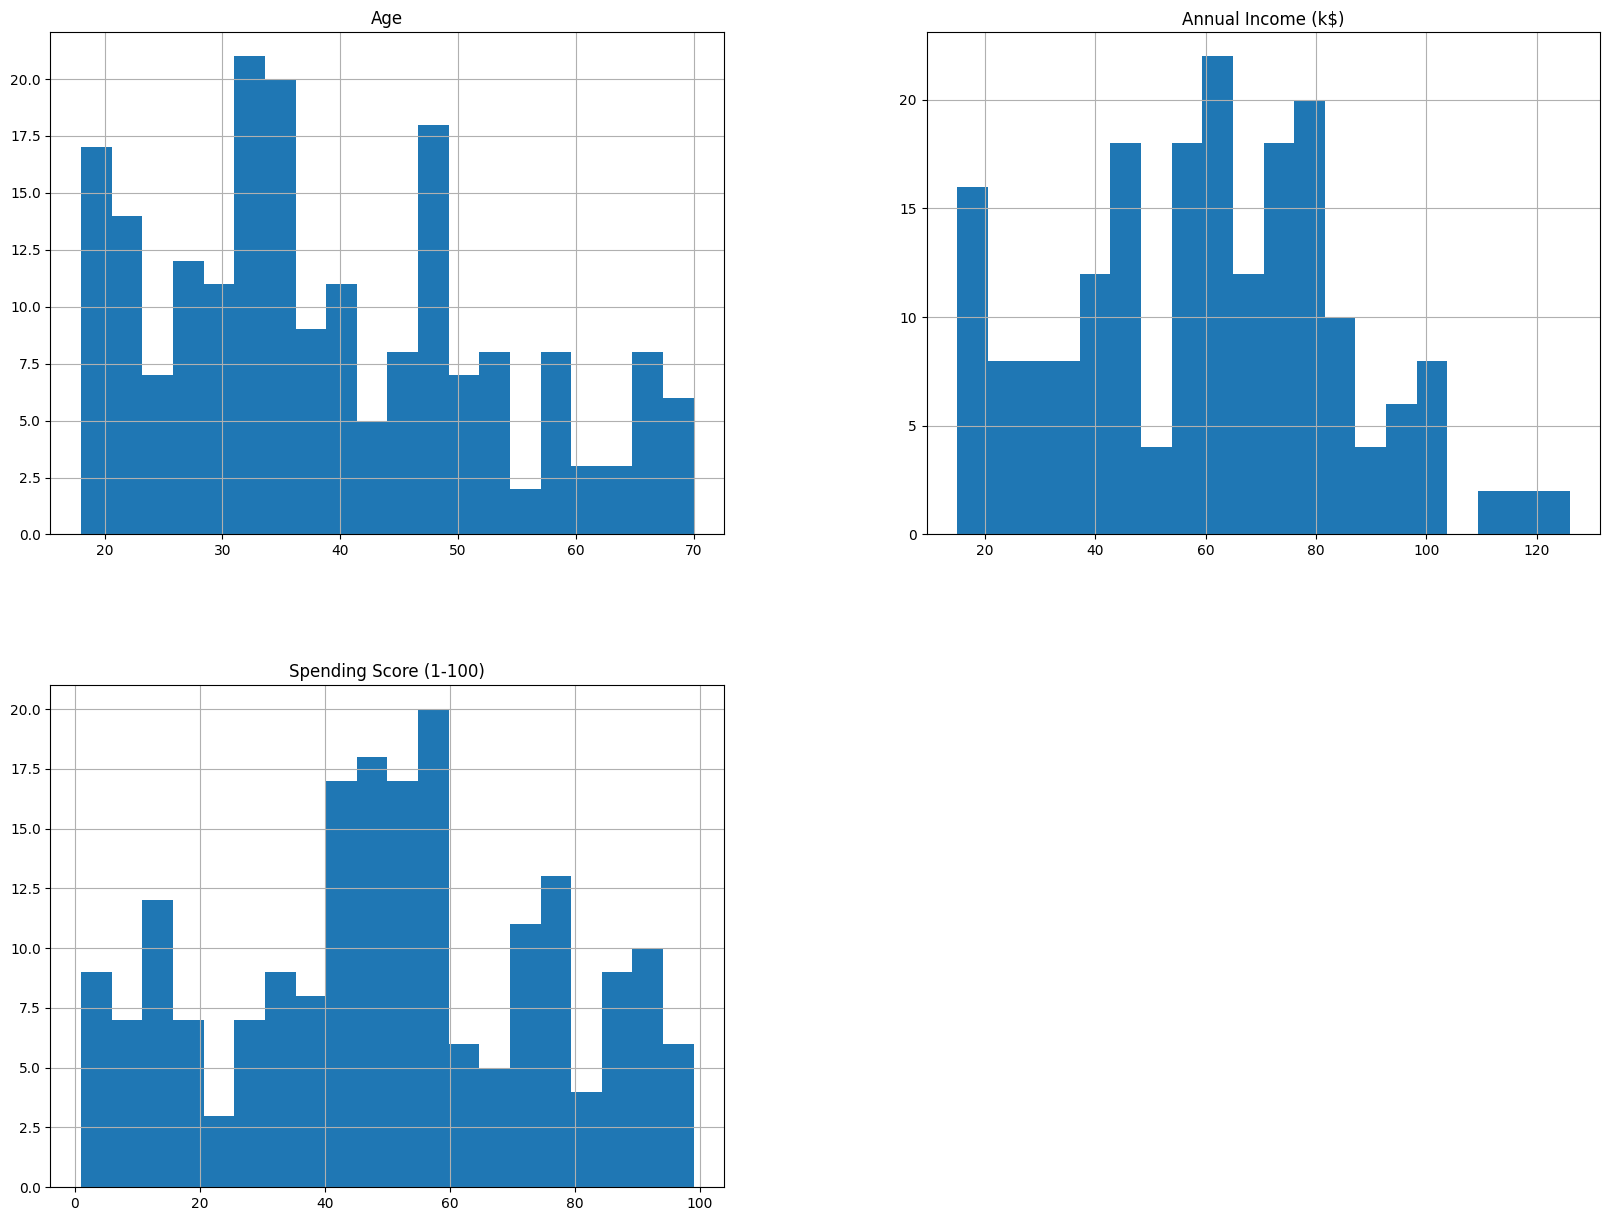

In [11]:
# Plot the distribution of the all columns after removing outliers
df.hist(bins=20, figsize=(20, 15))
plt.show()

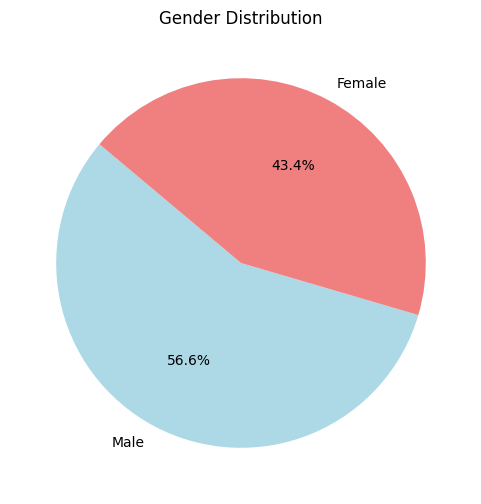

In [12]:
# Count the number of males and females
gender_counts = df['Gender'].value_counts()

# Plotting a circle counter
plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightcoral'])
plt.title('Gender Distribution')
plt.show()

In [13]:
# Gender is the only categorical column in the dataset and it will be the target column
# I will convert it to numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Convert the 'Gender' column to numerical using LabelEncoder
df['Gender'] = le.fit_transform(df['Gender'])

# Verify the conversion
print(df.head())

# Split the data into features and target
X = df.drop(columns=["Gender"],axis=1)
y = df["Gender"]

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       1   19                  15                      39
1       1   21                  15                      81
2       0   20                  16                       6
3       0   23                  16                      77
4       0   31                  17                      40


## Model building (Decision Tree)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# Splitting the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Creating a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Defining hyperparameters for tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],  # Example values, you can adjust this range
    'min_samples_split': [2, 5, 10],  # Example values, you can adjust this range
}

# Performing Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Building the Decision Tree model with the best hyperparameters
best_dt_model = DecisionTreeClassifier(**best_params)
print("Best Hyperparameters:", best_params)
best_dt_model.fit(X_train, y_train)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5}


DecisionTreeClassifier(max_depth=10, min_samples_split=5)

In [15]:
# Performing Recursive Feature Elimination
rfe = RFE(estimator=best_dt_model, n_features_to_select=5)  # Example value, adjust as needed
rfe.fit(X_train, y_train)

# Getting the selected features
selected_features = X.columns[rfe.support_]

# Training the final model on selected features
final_model = DecisionTreeClassifier(**best_params)
print("Selected Features:", selected_features)
final_model.fit(X_train[selected_features], y_train)

Selected Features: Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')


DecisionTreeClassifier(max_depth=10, min_samples_split=5)

### Model Evaluation using Classification Report and Confusion Matrix

In [16]:

from sklearn.metrics import accuracy_score, classification_report

# Evaluate the final model on the validation set
y_val_pred = final_model.predict(X_val[selected_features])

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy:", accuracy)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

Accuracy: 0.5


### Visualizing the confusion matrix as a heatmap

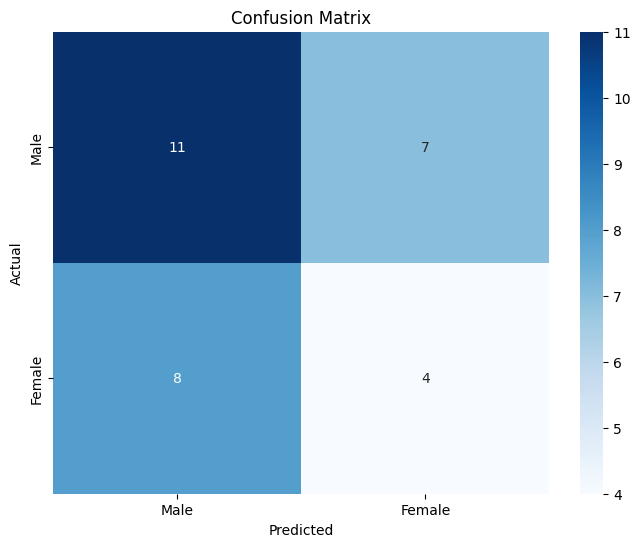

In [17]:
# Visualizing the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Generate and print classification report
class_report = classification_report(y_val, y_val_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.61      0.59        18
           1       0.36      0.33      0.35        12

    accuracy                           0.50        30
   macro avg       0.47      0.47      0.47        30
weighted avg       0.49      0.50      0.50        30



In [19]:
# the model shows bias towards the male class, which is evident from the confusion matrix and classification report
# I will try to improve the model by using a different algorithm
from sklearn.ensemble import RandomForestClassifier

# Creating a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Defining hyperparameters for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Example values, you can adjust this range
    'max_depth': [3, 5, 7, 10],  # Example values, you can adjust this range
    'min_samples_split': [2, 5, 10],  # Example values, you can adjust this range
}

# Performing Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Building the Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params)
print("Best Hyperparameters:", best_params)
best_rf_model.fit(X_train, y_train)

# Performing Recursive Feature Elimination
rfe = RFE(estimator=best_rf_model, n_features_to_select=5)  # Example value, adjust as needed
rfe.fit(X_train, y_train)

# Getting the selected features
selected_features = X.columns[rfe.support_]

# Training the final model on selected features
final_model = RandomForestClassifier(**best_params)
print("Selected Features:", selected_features)
final_model.fit(X_train[selected_features], y_train)

# Evaluate the final model on the validation set
y_val_pred = final_model.predict(X_val[selected_features])

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50}
Selected Features: Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')
Accuracy: 0.5666666666666667


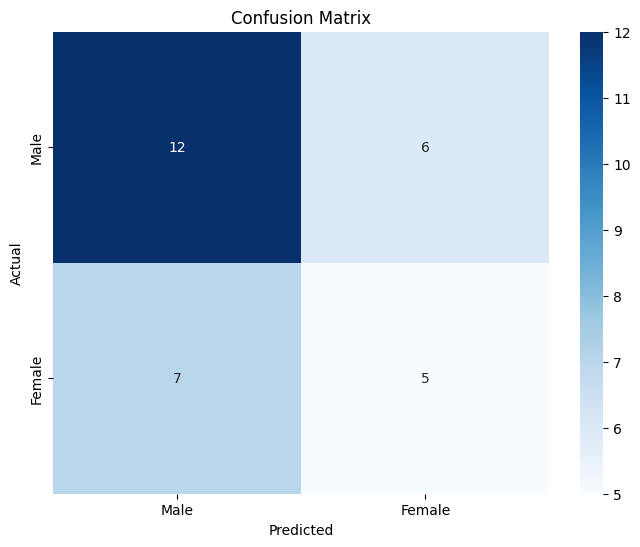

In [20]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Visualizing the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()